In [1]:
%load_ext autoreload
%autoreload 2

In [53]:
import numpy as np
import logging

from modules.transformers import Sequential, BitUnpacking, AuxDataCollector, Identity
from modules.transformers.cdr import SimpleCDR, MulticarrierCDR
from modules.transformers.framing import Deframer
from modules.transformers.demodulators import BFSKDemodulator, MFSKDemodulator
from modules.transformers.preprocessing import LogLoopAGC, CarrierDetectorExtractor
from modules.transformers.filters import DCBlocker
from modules.io import SoundDeviceSource, SoundFileSource

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger()

# BFSK

In [3]:
block_size = 4096
filename = "../evalulation/ex_test2/raw/fsk/3000_3200/100/0.3m/8bf989cb-b3d3-40d9-819c-188879af91d2.wav"
baudrate = 100

source = SoundFileSource(filename, block_size)
fs = source.fs
sps = fs // baudrate

In [5]:
sigdet = CarrierDetectorExtractor(
    fs=fs,
    carrier_cutoff=[2900, 3300],
    noise_delta=100,
    ntaps=1229,
    ema_alpha=0.6,
    snr_threshold_db=10,
    update_period=512,
)

agc = LogLoopAGC(
    step_size=0.2,
    update_period=512,
    ref=-3.0,
    gain_max=30.0
)

demod = BFSKDemodulator(
    fs=fs,
    f0=3000,
    f1=3200,
    f_delta=100,
    carrier_bandpass_ntaps=1229,
    symbol_lpf_cutoff_freq=1100,
    symbol_lpf_ntaps=405,
)

dcblocker = DCBlocker(
    # p=0.9998,
    s=9600,
    mode='ma'
)

cdr = SimpleCDR(
    sps=sps,
    clk_recovery_window=sps // 4,
    clk_recovery_grad_threshold=1e-3,
    median_window_size=int(sps * 0.8)
)

deframer = Deframer(
    format=Deframer.FormatType.RAW_PAYLOAD
)

pipeline = Sequential(sigdet, agc, demod, dcblocker, cdr, deframer)

f1_f0_diffs = np.array([], dtype=float)
symbols = np.array([], dtype=bool)
f0_amps = np.array([], dtype=float)
f1_amps = np.array([], dtype=float)
symbol_rising_edges = np.array([], dtype=float)
gains = np.array([], dtype=float)
snr_db = np.array([], dtype=float)
dc_blocker_out = np.array([], dtype=float)

with source:
    for block in source.stream:
        frames = pipeline(block)
        for frame in frames:
            logger.info(f"< {frame}")

        f1_f0_diffs = np.concatenate((f1_f0_diffs, demod.frag_f1_f0_diff))
        f0_amps = np.concatenate((f0_amps, demod.frag_f0_amp))
        f1_amps = np.concatenate((f1_amps, demod.frag_f1_amp))
        symbols = np.concatenate((symbols, cdr.symbols_hard))
        symbol_rising_edges = np.concatenate((symbol_rising_edges, cdr.symbol_rising_edges))
        gains = np.concatenate((gains, agc.frag_gain_interp))
        snr_db = np.concatenate((snr_db, sigdet.frag_snr_db))
        dc_blocker_out = np.concatenate((dc_blocker_out, dcblocker.frag_out))

hi22


INFO:modules.transformers.framing.deframer:Receiving message with length 11
INFO:modules.transformers.framing.deframer:Received raw message bytearray(b'hell/ wo2ld')
INFO:root:< b'hell/ wo2ld'


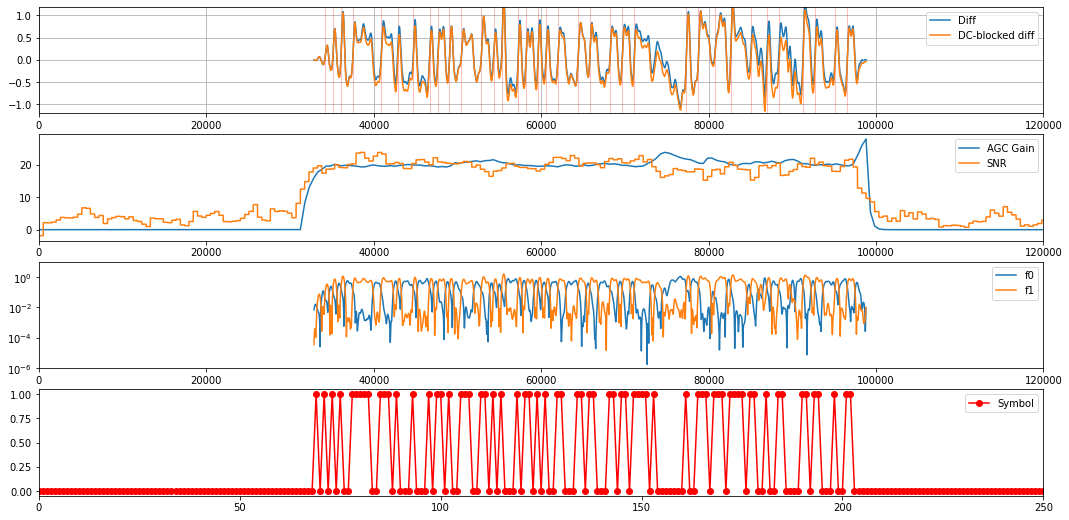

In [5]:
import matplotlib.pyplot as plt

start = 0
end = 2.5

plt.figure(1, figsize=(18, 9))
plt.clf()
plt.subplot(411)
for x in np.where(symbol_rising_edges == 1)[0]:
    plt.axvline(x=x, c="red", alpha=0.5, lw=0.5)
plt.xlim(start * fs, end * fs)
plt.ylim((-1.2, 1.2))
plt.plot(f1_f0_diffs, label="Diff")
plt.plot(dc_blocker_out, label="DC-blocked diff")
plt.grid(True)
plt.legend()

plt.subplot(412)
plt.xlim(start * fs, end * fs)
plt.plot(gains, label="AGC Gain")
plt.plot(snr_db, label="SNR")
# plt.ylim((0, 100))
plt.legend()

plt.subplot(413)
plt.plot(f0_amps, label="f0")
plt.plot(f1_amps, label="f1")
plt.xlim(start * fs, end * fs)
plt.yscale("log")
plt.ylim((1e-6, 10.0))
plt.legend()

plt.subplot(414)
plt.plot(symbols, 'ro-', label="Symbol")
plt.xlim(start * baudrate, end * baudrate)
plt.legend()

plt.show()

# MFSK4

In [62]:
filename = "../evalulation/ex_test3/raw/fsk/3000_3200_3600_3400/50/0.3m/1fcbd738-b5b6-4f0e-8cde-52c1790754bd.wav"
baudrate = 50
source = SoundFileSource(filename, block_size)
fs = source.fs
sps = fs // baudrate

pipeline = Sequential(
    CarrierDetectorExtractor(
        fs=fs,
        carrier_cutoff=[2900, 3700],
        noise_delta=100,
        ntaps=1229,
        ema_alpha=0.6,
        snr_threshold_db=10,
        update_period=512,
    ),
    LogLoopAGC(
        step_size=0.2,
        update_period=512,
        ref=-3.0,
        gain_max=50.0
    ),
    MFSKDemodulator(
        fs=fs,
        freqs=[3000, 3200, 3600, 3400],
        f_delta=100,
        carrier_bandpass_ntaps=1229,
        symbol_lpf_cutoff_freq=1100,
        symbol_lpf_ntaps=405,
    ),
    MulticarrierCDR(
        sps=sps,
        clk_recovery_window=sps // 4,
        clk_recovery_grad_threshold=1e-3,
        median_window_size=int(sps * 0.8)
    ),
    BitUnpacking(
        count=2
    ),
    Deframer(
        format=Deframer.FormatType.RAW_PAYLOAD
    )
)

sigdet, agc, demod, cdr, bitunpacker, deframer = pipeline.children

pipeline = AuxDataCollector(pipeline, {
    "input_snr": lambda: sigdet.frag_snr_db,
    "agc_gain": lambda: agc.frag_gain_interp,
    "subcarrier_abs_amp": lambda: demod.frag_fi_envelope,
    "subcarrier_rela_amp": lambda: demod.frag_diff,
    "symbols": lambda: cdr.symbols_hard,
    "symbol_rising_edges": lambda: cdr.symbol_rising_edges_combined,
})

with source:
    for block in source.stream:
        frames = pipeline(block)
        for frame in frames:
            logger.info(f"< {frame}")

INFO:modules.transformers.framing.deframer:Receiving message with length 11
INFO:modules.transformers.framing.deframer:Received raw message bytearray(b'hello world')
INFO:root:< b'hello world'


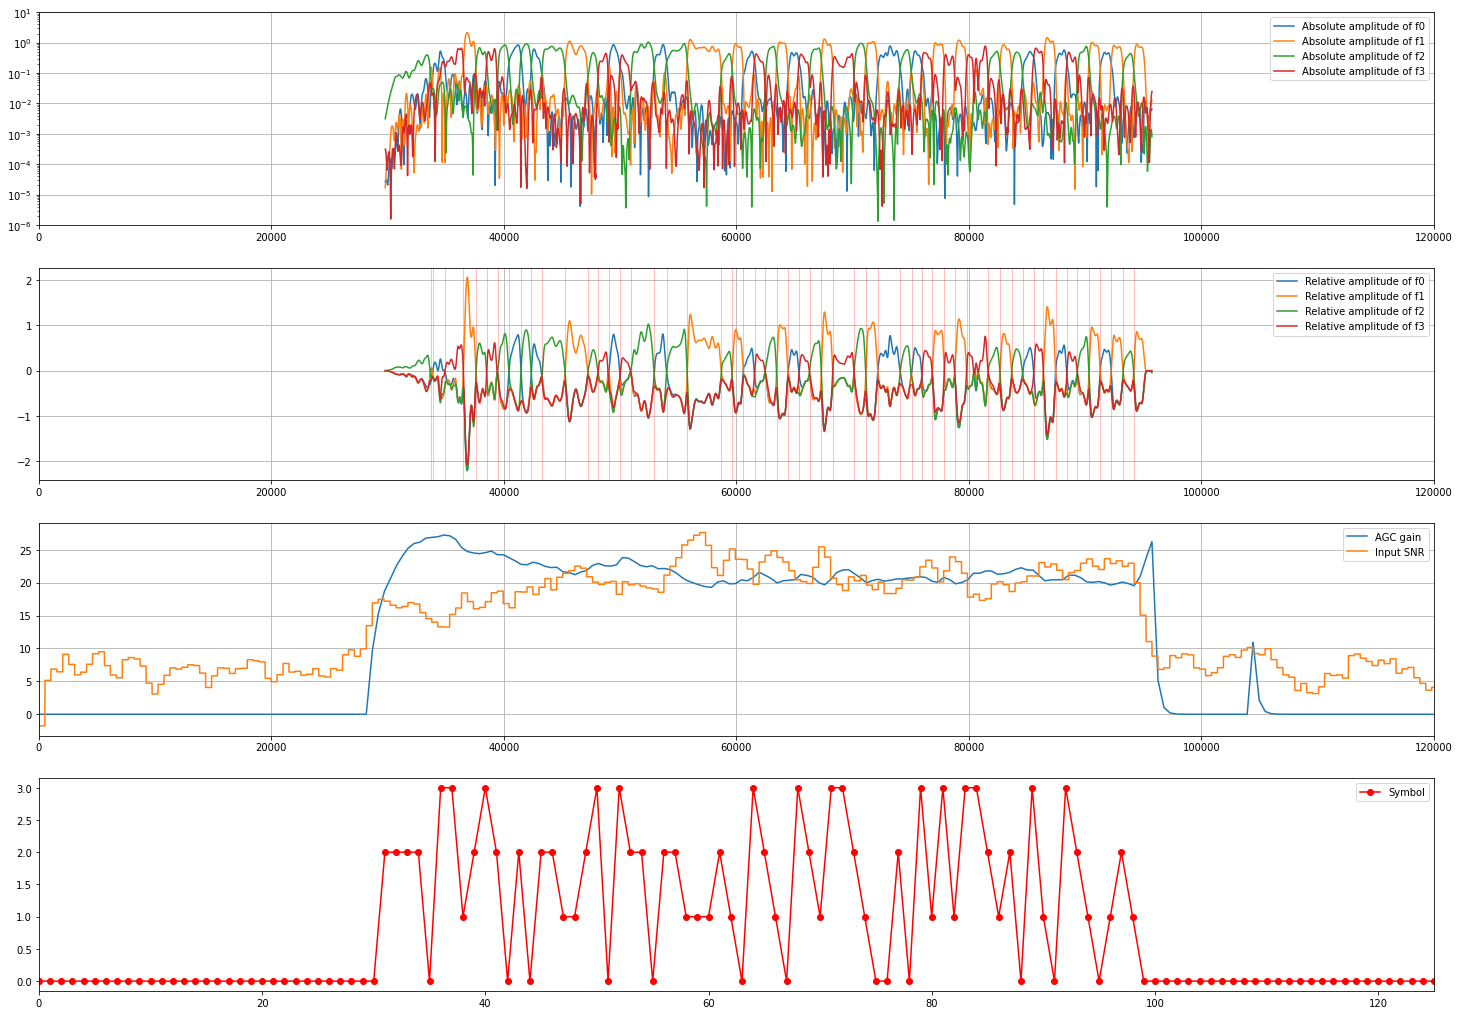

In [65]:
import matplotlib.pyplot as plt

start, end = (0, 2.5)

plt.figure(1, figsize=(25, 18))
plt.clf()

# =======================

plt.subplot(411)

for i, x in enumerate(pipeline.cum_data["subcarrier_abs_amp"]):
    plt.plot(x, label=f"Absolute amplitude of f{i}")
plt.xlim(start * fs, end * fs)
plt.yscale("log")
plt.ylim((1e-6, 10.0))
plt.grid(True)
plt.legend()

# =======================

plt.subplot(412)

for i, x in enumerate(pipeline.cum_data["subcarrier_rela_amp"]):
    plt.plot(x, label=f"Relative amplitude of f{i}")

for x in np.where(pipeline.cum_data["symbol_rising_edges"] == 1)[0]:
    plt.axvline(x=x, c="red", alpha=0.5, lw=0.5)

plt.xlim(start * fs, end * fs)
plt.legend()
plt.grid(True)

# =======================

plt.subplot(413)
plt.plot(pipeline.cum_data["agc_gain"], label="AGC gain")
plt.plot(pipeline.cum_data["input_snr"], label="Input SNR")
plt.xlim(start * fs, end * fs)
plt.legend()
plt.grid(True)

# =======================

plt.subplot(414)
plt.plot(pipeline.cum_data["symbols"], 'ro-', label="Symbol")
plt.xlim(start * baudrate, end * baudrate)
plt.legend()

plt.show()